In [ ]:
import datasets
import pandas as pd

In [ ]:
df_test = pd.read_csv("/kaggle/input/nlp-ua-locations-extractions/test.csv")

In [ ]:
from transformers import pipeline

# Replace this with your own checkpoint
model_checkpoint = "/kaggle/input/multibert-combined/multibert-ner-combined/checkpoint-25000/"
token_classifier = pipeline(
    "token-classification", model=model_checkpoint, aggregation_strategy="simple"
)

In [ ]:
df_test.loc[1, "text"]

In [ ]:
token_classifier(df_test.loc[1, "text"])

In [ ]:
import emoji
import spacy
import re

In [ ]:
def contains_emoji(text):
    for char in text:
        if emoji.is_emoji(char):
            return True
    else:
        return False

def extract_locations(text, th=0.95):    
    
    ents = token_classifier(text)
    res = []
    for ent in ents:
        if ent['score'] >= th and "#" not in ent['word'] and not contains_emoji(ent['word']):
            word = re.sub(r"\s*([ʼ\'’-])\s*", r"\1", ent['word'])
            res.append(word)
    
    return res

In [ ]:
df_test.loc[106:107, "text"].apply(extract_locations)

In [ ]:
df_test.loc[106:107, "text"].apply(extract_locations)[107][1] == "просп. Берестейський, 25-А"

In [12]:
from tqdm.auto import tqdm
tqdm.pandas()

In [13]:
df_test['locations'] = df_test['text'].progress_apply(extract_locations, th=0.93)

  0%|          | 0/477 [00:00<?, ?it/s]

In [25]:
df_test[['text_id', 'locations']].to_csv('multibert_comb_093.csv', index=False)

In [14]:
df_test

,text_id,text,locations
0,0,"❗️Кількість поранених зросла до трьох, – Кличк...",[]
1,1,"🥤В Києві за 91,13 млн гривень починаються робо...",[Києві]
2,2,▪️Сьогодні вночі росіяни завдали ракетного уда...,"[Гоголеве, Миргородського району, Полтавської ..."
3,3,Наразі у запасах росіян найбільше балістичних ...,[]
4,4,"⛸В один день, 29 серпня, ДП ""Центральна учбово...",[]
...,...,...,...
472,472,Допомога на відновлення: п’ять громад Київщини...,"[Київщини, України, Київської області, Бучансь..."
473,473,Пророцтво Стругацьких: незвичайна бактерія Бра...,[]
474,474,Із 1 вересня УГКЦ і ПЦУ перейшли на новий церк...,[України]
475,475,🦇 У Києві з Дніпра виловили іноземця в масці Б...,"[Києві, Дніпра, Дніпро]"


In [15]:
df_sample = pd.read_csv("/kaggle/input/nlp-ua-locations-extractions/labeling_sample.csv", converters={"locations": eval})

In [16]:
df_sample['locations_pred'] = df_sample['text'].progress_apply(extract_locations)

  0%|          | 0/26 [00:00<?, ?it/s]

In [17]:
from typing import List
import re

def hard_processing(text):
    text = re.sub(r"[{re.escape(string.punctuation)}]", "", text)
    text = re.sub(r'\d', '', text)
    text = re.sub(r'\b\w\b\s?', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text.lower()

def comp_metric(y_true: List[List[str]], y_pred: List[List[str]]):
    assert len(y_true) == len(y_pred)
    tp, fp, fn = 0.0, 0.0, 0.0

    for y_true_sample, y_pred_sample in zip(y_true, y_pred):
        y_true_sample = set([hard_processing(s) for s in y_true_sample])
        y_pred_sample = set([hard_processing(s) for s in y_pred_sample])
        tp += len(set(y_true_sample) & set(y_pred_sample))
        fp += len(set(y_pred_sample) - set(y_true_sample))
        fn += len(set(y_true_sample) - set(y_pred_sample))
    
    precision = tp / (tp + fp) if tp + fp != 0 else 0.0 if tp + fn != 0.0 else 1.0
    recall = tp / (tp + fn) if tp + fn != 0 else 1.0
    f1 = 2 * precision * recall / (precision + recall) if precision + recall != 0 else 0.0

    return {
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

In [18]:
comp_metric(df_sample['locations'], df_sample['locations_pred'])

{'precision': 0.525, 'recall': 0.65625, 'f1': 0.5833333333333334}

## Tets different thresholds

In [19]:
import numpy as np
import matplotlib.pyplot as plt


In [20]:
f1_scores = []
precisions = []
recalls = []

for th in tqdm(np.arange(0.85, 0.99, 0.01)):
    pred = df_sample['text'].apply(extract_locations, th=th)
    metrics = comp_metric(df_sample['locations'], pred)
    f1_scores.append(metrics['f1'])
    precisions.append(metrics['precision'])
    recalls.append(metrics['recall'])

  0%|          | 0/15 [00:00<?, ?it/s]

In [21]:
ths = np.arange(0.85, 0.99, 0.01)

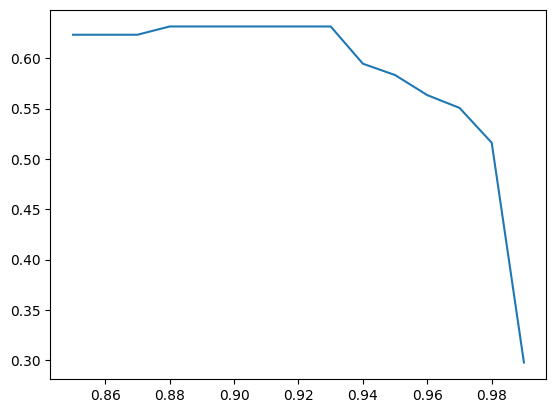

In [22]:
plt.plot(ths, f1_scores)

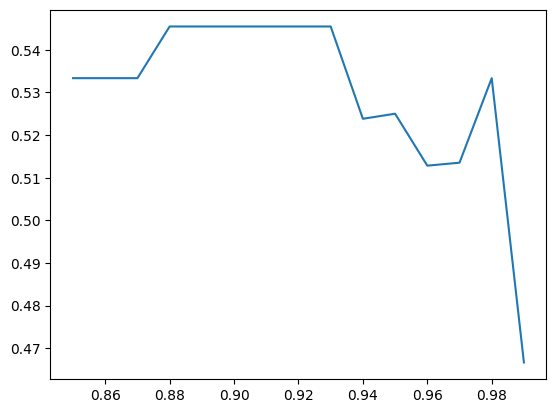

In [23]:
plt.plot(ths, precisions)

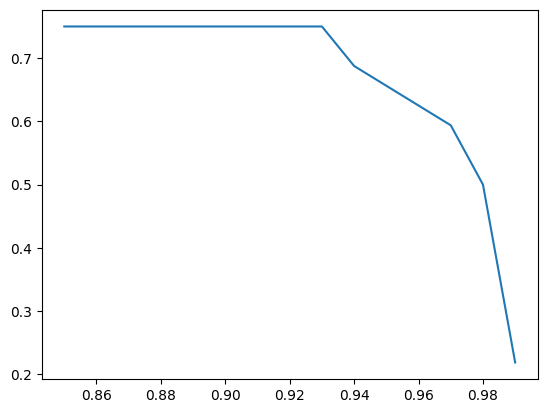

In [24]:
plt.plot(ths, recalls)